In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
import cv2
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,silhouette_score 
from sklearn.cluster import KMeans,DBSCAN
from scipy.spatial import distance
from functools import reduce
import wfdb#https://github.com/MIT-LCP/wfdb-python
from wfdb import processing
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.cuda.set_device(2)
print (torch.cuda.current_device())

2


In [2]:
rootdir = '/data/fjsdata/physionet/MIT-BIH/mitdb/'
rootdir = '/data/fjsdata/physionet/MIT-BIH/mitdb/'
right_len = 180 #right sample length around of peak value of QRS
left_len = 180 #left sample length around of peak value of QRS
#train data
trPVC = [] #[Subject,sig_name,QRS]
for bt in [101,106,108,109,112,114,115,116,118,119,122,124,201,203,205,207,208,209,215,220,223,230,\
            100,103,105,111,113,117,121,123,200,202,210,212,213,214,219,221,222,228,231,232,233,234]:
    #44 records for train
    file = os.path.join(rootdir,str(bt))
    try:
        annotation = wfdb.rdann(file, 'atr') 
        qrs_spl = annotation.sample #numpy.ndarray
        qrs_sym = annotation.symbol #list
        record = wfdb.rdrecord(file)
        signal = record.p_signal #numpy.ndarray
        max_len = record.sig_len #length of samples
        lead_name =  record.sig_name #names of lead channels,list
        for i in range(annotation.ann_len):
            if qrs_sym[i] in ['V']:#PVC samples
                pos = qrs_spl[i] #corresponding position of peak value of QRS
                if pos+right_len<=max_len and pos-left_len>=0:
                    max_idx = pos+right_len#np.min([max_len, pos+trunc_len])
                    min_idx = pos-left_len#np.max([0, pos-trunc_len])
                    for j, val in enumerate(lead_name):
                        if val == 'MLII':
                            QRS_value = signal[:,j][min_idx:max_idx]
                            trPVC.append([bt,QRS_value])#[Subject,sig_name,QRS]
    except: pass
trPVC = pd.DataFrame(np.array(trPVC),columns=['sub','qrs'])
trPVC_QRS = pd.DataFrame(trPVC['qrs'].values.tolist()) #QRS extrend
trPVC = trPVC.drop(['qrs'],axis=1) #drop column 2
trPVC = pd.concat([trPVC, trPVC_QRS], axis=1)
print('The shape of MIT-BIH for PVC trainset is: (%d,%d)'%(trPVC.shape[0],trPVC.shape[1]))

#test data
txt_dir = '/data/fjsdata/ECG/PVC/MIT-BIH-label/' #the path of images
sgl_dir = '/data/fjsdata/physionet/MIT-BIH/mitdb/'
tePVC = []#[Subject,QRS,PVC label]
for iname in os.listdir(txt_dir):
    #read label 
    txt_path = os.path.join(txt_dir, iname) 
    label_list = []
    with open(txt_path,'r') as f:
        for line in f:
            label_list.append(line.strip('\n'))
    bt = os.path.splitext(iname)[0]
    sgl_path = os.path.join(sgl_dir,str(bt))
    #read positon of PVC
    annotation = wfdb.rdann(sgl_path, 'atr') 
    qrs_spl = annotation.sample #numpy.ndarray
    qrs_sym = annotation.symbol #list
    pos_list = []
    for i in range(annotation.ann_len):
        if qrs_sym[i] in ['V']:#PVC samples
            pos = qrs_spl[i] #corresponding position of peak value of QRS
            pos_list.append(qrs_spl[i])
    #read signal        
    record = wfdb.rdrecord(sgl_path)
    signal = record.p_signal #numpy.ndarray
    max_len = record.sig_len #length of samples
    lead_name =  record.sig_name #names of lead channels,list
    for i in range(len(label_list)):
        pos = pos_list[i]
        if pos+right_len<=max_len and pos-left_len>=0:
            max_idx = pos+right_len#np.min([max_len, pos+trunc_len])
            min_idx = pos-left_len#np.max([0, pos-trunc_len])
            for j, val in enumerate(lead_name):
                if val == 'MLII':
                    QRS_value = signal[:,j][min_idx:max_idx]
                    tePVC.append([bt,label_list[i],QRS_value])
tePVC = pd.DataFrame(np.array(tePVC),columns=['sub','label','qrs'])
tePVC_QRS = pd.DataFrame(tePVC['qrs'].values.tolist()) #QRS extrend
tePVC = tePVC.drop(['qrs'],axis=1) #drop column 2
tePVC = pd.concat([tePVC, tePVC_QRS], axis=1)
print('The shape of MIT-BIH for PVC testset is: (%d,%d)'%(tePVC.shape[0],tePVC.shape[1]))

The shape of MIT-BIH for PVC trainset is: (6902,361)
The shape of MIT-BIH for PVC testset is: (1996,362)


In [61]:
#Training cluster model
X = trPVC.drop(['sub'],axis=1).reset_index(drop=True) 
best_score = 0.0
best_k = 1
distortions = []
for k in range(2,9):
    estimator = KMeans(n_clusters=k, random_state=0).fit(X)
    distortions.append(estimator.inertia_)
    si_score = silhouette_score(X,estimator.labels_,metric='euclidean')
    if si_score>best_score:
        best_score = si_score
        best_k = k
print('best K is:%d and its silhouette score is:%f'%(best_k,best_score))
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(X)

#Testing cluster model with true label
sub_list = list(set(np.array(tePVC['sub']).tolist()))
y_pred, y_true = [], []
for bt in sub_list:
    sub_df =  tePVC[tePVC['sub']==bt]
    if (sub_df.shape[0]>1): 
        X = sub_df.drop(['sub','label'],axis=1).reset_index(drop=True) 
        y = list(set(np.array(sub_df['label']).tolist()))
        if len(y)==1: y_true.append(0) #unifocal
        else:  y_true.append(1) #multifocal
        k = list(set(kmeans.predict(X).tolist()))
        if len(k)==1: y_pred.append(0) #unifocal
        else:  y_pred.append(1) #multifocal
print ( 'Accuracy: %.6f'%accuracy_score(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred, labels=[0,1] ) 
print (cm) 
print ('Sensitivity of unifocal pvc: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of multifocal pvc: %.6f'%float(cm[1][1]/np.sum(cm[1])))

best K is:3 and its silhouette score is:0.353035
Accuracy: 0.857143
[[ 4  3]
 [ 1 20]]
Sensitivity of unifocal pvc: 0.571429
Sensitivity of multifocal pvc: 0.952381


Org data dimension is 360.Embedded data dimension is 2


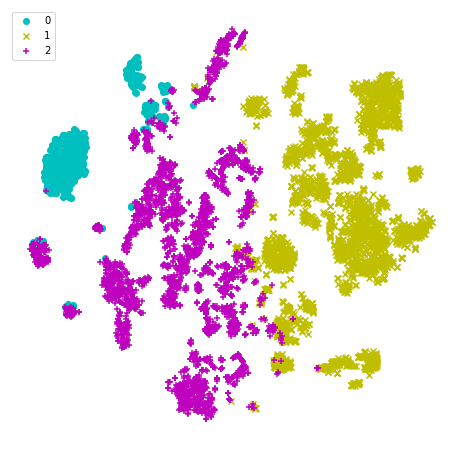

In [63]:
#visualize : t-SNE
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import random
def scatter(X, y):
    #X,y:numpy-array
    classes = len(list(set(y.tolist())))#get number of classes
    #palette = np.array(sns.color_palette("hls", classes))# choose a color palette with seaborn.
    color = ['c','y','m','b','g','r']
    marker = ['o','x','+','*','s']
    plt.figure(figsize=(8,8))#create a plot
    for i in range(classes):
        plt.scatter(X[y == i,0], X[y == i,1], c=color[i], marker=marker[i], label=str(i))
    plt.axis('off')
    plt.legend(loc='upper left')
    #plt.savefig('digits_tsne-generated.png', dpi=100)
    plt.show()

trF = trPVC.drop(['sub'],axis=1).reset_index(drop=True) 
trY = kmeans.predict(trF)
#prepare data，classes=3
idx= np.where(np.array(trY)==0)[0].tolist()
X0= np.array(trF)[idx]
y0= np.array(trY)[idx]

idx= np.where(np.array(trY)==1)[0].tolist()
X1= np.array(trF)[idx]
y1= np.array(trY)[idx]

idx= np.where(np.array(trY)==2)[0].tolist()
X2= np.array(trF)[idx]
y2= np.array(trY)[idx]

y = np.append(y0,y1)
y = np.append(y,y2)
X = np.vstack((X0,X1))
X = np.vstack((X,X2))
#training t-sne 
tsne = TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)
print("Org data dimension is {}.Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))

#visualize
scatter(X_tsne, y)

In [9]:
#Training cluster model
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

X = trPVC.drop(['sub'],axis=1).reset_index(drop=True) 
X = trPVC.drop(['sub'],axis=1).reset_index(drop=True) 
X = tanh(np.array(X)) #X = np.sign(X)
best_score = 0.0
best_k = 1
distortions = []
for k in range(2,9):
    estimator = KMeans(n_clusters=k, random_state=0).fit(X)
    distortions.append(estimator.inertia_)
    si_score = silhouette_score(X,estimator.labels_,metric='euclidean')
    if si_score>best_score:
        best_score = si_score
        best_k = k
print('best K is:%d and its silhouette score is:%f'%(best_k,best_score))
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(X)

#Testing cluster model with true label
sub_list = list(set(np.array(tePVC['sub']).tolist()))
y_pred, y_true = [], []
for bt in sub_list:
    sub_df =  tePVC[tePVC['sub']==bt]
    if (sub_df.shape[0]>1): 
        X = sub_df.drop(['sub','label'],axis=1).reset_index(drop=True) 
        X = tanh(np.array(X))
        y = list(set(np.array(sub_df['label']).tolist()))
        if len(y)==1: y_true.append(0) #unifocal
        else:  y_true.append(1) #multifocal
        k = list(set(kmeans.predict(X).tolist()))
        if len(k)==1: y_pred.append(0) #unifocal
        else:  y_pred.append(1) #multifocal
print ( 'Accuracy: %.6f'%accuracy_score(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred, labels=[0,1] ) 
print (cm) 
print ('Sensitivity of unifocal pvc: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of multifocal pvc: %.6f'%float(cm[1][1]/np.sum(cm[1])))

best K is:2 and its silhouette score is:0.353060
Accuracy: 0.857143
[[ 6  1]
 [ 3 18]]
Sensitivity of unifocal pvc: 0.857143
Sensitivity of multifocal pvc: 0.857143


Org data dimension is 360.Embedded data dimension is 2


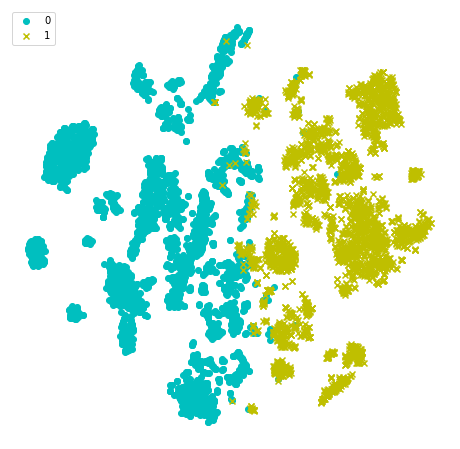

In [10]:
#visualize : t-SNE
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import random
def scatter(X, y):
    #X,y:numpy-array
    classes = len(list(set(y.tolist())))#get number of classes
    #palette = np.array(sns.color_palette("hls", classes))# choose a color palette with seaborn.
    color = ['c','y','m','b','g','r']
    marker = ['o','x','+','*','s']
    plt.figure(figsize=(8,8))#create a plot
    for i in range(classes):
        plt.scatter(X[y == i,0], X[y == i,1], c=color[i], marker=marker[i], label=str(i))
    plt.axis('off')
    plt.legend(loc='upper left')
    #plt.savefig('digits_tsne-generated.png', dpi=100)
    plt.show()

trF = trPVC.drop(['sub'],axis=1).reset_index(drop=True) 
trY = kmeans.predict(trF)
#prepare data，classes=3
idx= np.where(np.array(trY)==0)[0].tolist()
X0= np.array(trF)[idx]
y0= np.array(trY)[idx]

idx= np.where(np.array(trY)==1)[0].tolist()
X1= np.array(trF)[idx]
y1= np.array(trY)[idx]

idx= np.where(np.array(trY)==2)[0].tolist()
X2= np.array(trF)[idx]
y2= np.array(trY)[idx]

y = np.append(y0,y1)
y = np.append(y,y2)
X = np.vstack((X0,X1))
X = np.vstack((X,X2))
#training t-sne 
tsne = TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)
print("Org data dimension is {}.Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))

#visualize
scatter(X_tsne, y)

In [6]:
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

#Testing hamming distance with true label
sub_list = list(set(np.array(tePVC['sub']).tolist()))
y_pred, y_true = [], []
for bt in sub_list:
    sub_df =  tePVC[tePVC['sub']==bt]
    if (sub_df.shape[0]>1): 
        y = list(set(np.array(sub_df['label']).tolist()))
        if len(y)==1: y_true.append(0) #unifocal
        else:  y_true.append(1) #multifocal
        #calculate hanmming distance
        X = sub_df.drop(['sub','label'],axis=1).reset_index(drop=True) 
        X = np.sign(tanh(np.array(X))) 
        k = 1
        for i in range(X.shape[0]):
            for j in range(i+1,X.shape[0]):
                dist = pdist(np.vstack([X[i],X[j]]),'hamming')
                if dist>0.3: k = k+1
        if k==1: y_pred.append(0) #unifocal
        else:  y_pred.append(1) #multifocal
            
print ( 'Accuracy: %.6f'%accuracy_score(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred, labels=[0,1] ) 
print (cm) 
print ('Sensitivity of unifocal pvc: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of multifocal pvc: %.6f'%float(cm[1][1]/np.sum(cm[1])))

Accuracy: 0.857143
[[ 5  2]
 [ 2 19]]
Sensitivity of unifocal pvc: 0.714286
Sensitivity of multifocal pvc: 0.904762


In [23]:
#Testing Euclidean distance with true label
sub_list = list(set(np.array(tePVC['sub']).tolist()))
y_pred, y_true = [], []
for bt in sub_list:
    sub_df =  tePVC[tePVC['sub']==bt]
    if (sub_df.shape[0]>1): 
        y = list(set(np.array(sub_df['label']).tolist()))
        if len(y)==1: y_true.append(0) #unifocal
        else:  y_true.append(1) #multifocal
        #calculate hanmming distance
        X = sub_df.drop(['sub','label'],axis=1).reset_index(drop=True) 
        X = np.array(X)
        k = 1
        for i in range(X.shape[0]):
            for j in range(i+1,X.shape[0]):
                dist = distance.cosine(X[i],X[j])
                if dist>0.6: k = k+1
        if k==1: y_pred.append(0) #unifocal
        else:  y_pred.append(1) #multifocal
            
print ( 'Accuracy: %.6f'%accuracy_score(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred, labels=[0,1] ) 
print (cm) 
print ('Sensitivity of unifocal pvc: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of multifocal pvc: %.6f'%float(cm[1][1]/np.sum(cm[1])))

Accuracy: 0.857143
[[ 5  2]
 [ 2 19]]
Sensitivity of unifocal pvc: 0.714286
Sensitivity of multifocal pvc: 0.904762


In [29]:
def svd_denoise(img):
    u, sigma, vt = np.linalg.svd(img)
    h, w = img.shape[:2]
    h1 = int(h * 0.2) #Singular Value
    sigma1 = np.diag(sigma[:h1],0) #generate diagnal matrix
    u1 = np.zeros((h,h1), float)
    u1[:,:] = u[:,:h1]
    vt1 = np.zeros((h1,w), float)
    vt1[:,:] = vt[:h1,:]
    return u1.dot(sigma1).dot(vt1)

def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
#Testing Euclidean distance with true label
sub_list = list(set(np.array(tePVC['sub']).tolist()))
y_pred, y_true = [], []
for bt in sub_list:
    sub_df =  tePVC[tePVC['sub']==bt]
    if (sub_df.shape[0]>1): 
        y = list(set(np.array(sub_df['label']).tolist()))
        if len(y)==1: y_true.append(0) #unifocal
        else:  y_true.append(1) #multifocal
        #calculate hanmming distance
        X = sub_df.drop(['sub','label'],axis=1).reset_index(drop=True) 
        X = svd_denoise(np.array(X))
        k = 1
        for i in range(X.shape[0]):
            for j in range(i+1,X.shape[0]):
                dist = distance.cosine(X[i],X[j])
                if dist>0.6: k = k+1
        if k==1: y_pred.append(0) #unifocal
        else:  y_pred.append(1) #multifocal
            
print ( 'Accuracy: %.6f'%accuracy_score(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred, labels=[0,1] ) 
print (cm) 
print ('Sensitivity of unifocal pvc: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of multifocal pvc: %.6f'%float(cm[1][1]/np.sum(cm[1])))

Accuracy: 0.857143
[[ 5  2]
 [ 2 19]]
Sensitivity of unifocal pvc: 0.714286
Sensitivity of multifocal pvc: 0.904762
